In [1]:
import pathlib
import tempfile

import torch
import torchvision
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import roma
import tqdm

from Unet2 import UNet
from se3 import se3_log_map, se3_exp_map

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def transform_from_params(params):
    return se3_exp_map(params).mT

In [3]:
def params_from_transform(transform):
    return se3_log_map(transform.mT)

In [4]:
def pose_from_transform(transform):
    return transform[..., :3, :3], transform[..., :3,[3]]

In [23]:
class CarlaTriplesDataset(torch.utils.data.Dataset):
    
    def __init__(self, dataset):
        self.K = torch.from_numpy(dataset['K']).float()
        self.K[0] = self.K[0] /800
        self.K[1] = self.K[1] /600
        self.rgbs = dataset['rgbs']
        self.depths = dataset['depths']
        self.transforms = dataset['transforms']

    def __len__(self):
        # The size of the dataset should be the number of triples
        # We will assume that each query image uses its adjacent images,
        # so we have N - 2 query images
        return len(self.transforms) - 2

    def __getitem__(self, idx):
        # Our query images in CHW format
        # Note for Yuxin: The images needed to be divided by 255!
        image_q = torch.from_numpy(self.rgbs[idx+0].copy()[:500,:]).permute(2, 0, 1) / 255
        image_0 = torch.from_numpy(self.rgbs[idx+1].copy()[:500,:]).permute(2, 0, 1) / 255
        image_1 = torch.from_numpy(self.rgbs[idx+2].copy()[:500,:]).permute(2, 0, 1) / 255
        # Our depth images i
        depth_q = torch.from_numpy(self.depths[idx+0].copy()[:500,:] * 1000)
        depth_0 = torch.from_numpy(self.depths[idx+1].copy()[:500,:] * 1000)
        depth_1 = torch.from_numpy(self.depths[idx+2].copy()[:500,:] * 1000)

        # Deal with the handness difference between intrinsic and carla extrinsic
        # The mapping is x, y, z -> -z, x, y
        axes = torch.tensor([
            [0, 0,-1, 0],
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 0, 1],
        ]).double()
        # axes = torch.eye(4).double()
        # Our poses
        extrinsic_q = torch.from_numpy(self.transforms[idx+0]) @ axes
        extrinsic_0 = torch.from_numpy(self.transforms[idx+1]) @ axes
        extrinsic_1 = torch.from_numpy(self.transforms[idx+2]) @ axes
        
        transform_q0 = torch.linalg.inv(extrinsic_0) @ extrinsic_q
        transform_q1 = torch.linalg.inv(extrinsic_1) @ extrinsic_q
        transform_01 = torch.linalg.inv(extrinsic_1) @ extrinsic_0
        
        #transformation: resize from 600*800 to 120 160
        # resize = torchvision.transforms.Resize((120,160))
        # resize = torchvision.transforms.Resize((600 // 2, 400 // 2))
        resize = torchvision.transforms.Resize((250,400))
        return (
            self.K.unsqueeze(0),
            resize.forward(image_q),
            resize.forward(image_0),
            resize.forward(image_1),
            resize.forward(depth_q.unsqueeze(0)).squeeze(),
            resize.forward(depth_0.unsqueeze(0)).squeeze(),
            resize.forward(depth_1.unsqueeze(0)).squeeze(),
            transform_q0.float(),
            transform_q1.float(),
            transform_01.float(),
        )
        # return self.K.unsqueeze(0),image_q,image_0,image_1,depth_q,depth_0,depth_1,pose_q0, pose_q1, pose_01
        # return self.K.unsqueeze(0), torchvision.transforms.functional.resize(image_q,(60,120)), torchvision.transforms.functional.resize(image_0,(60,120)), torchvision.transforms.functional.resize(image_1,(60,120)), torchvision.transforms.functional.resize(depth_q,(60,120)), torchvision.transforms.functional.resize(depth_0,(60,120)), torchvision.transforms.functional.resize(depth_1,(60,120)), pose_q0, pose_q1, pose_01

In [24]:
def load_data_as_memmap(filename, directory):
    directory = pathlib.Path(directory)
    dataset = np.load(filename)
        
    output = {
        'K': dataset['K'],
        'transforms': dataset['transforms'],
    }
    
    # Send the RGB & depth data to a file on disk to avoid OOM
    for key in ('rgbs', 'depths'):
        data = dataset[key]
        filename = directory / f'{key}.npy'
        fp = np.memmap(filename, dtype='float32', mode='w+', shape=data.shape)
        fp[:] = data[:]
        output[key] = np.memmap(filename, dtype='float32', mode='r', shape=data.shape)
    return output

In [25]:
memmap = load_data_as_memmap('data-2023-03-03.npz', tempfile.mkdtemp())

In [26]:
dataset = CarlaTriplesDataset(memmap)

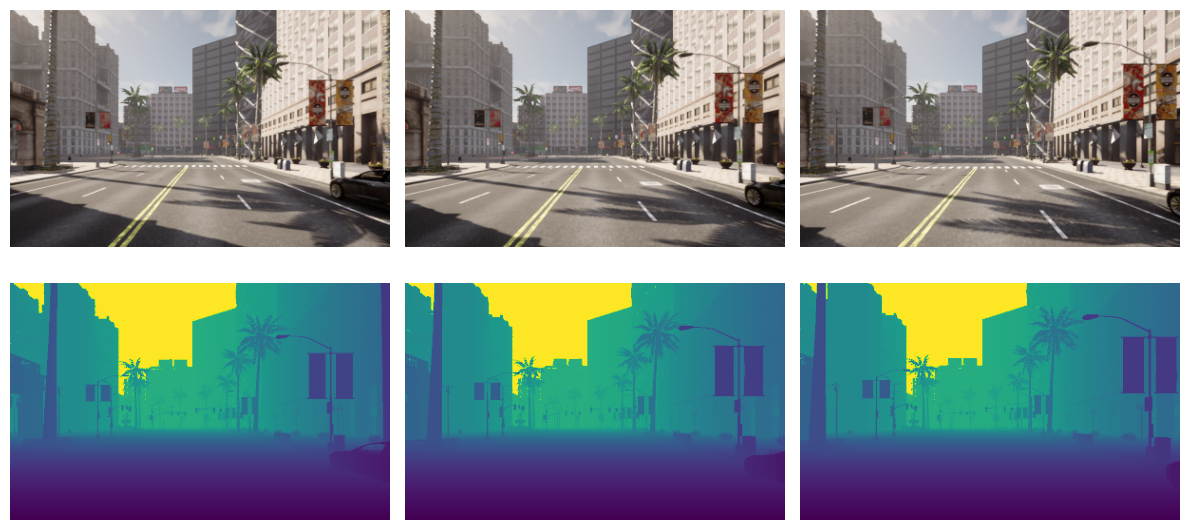

In [47]:
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_q0, transform_q1, transform_01 = dataset[23]

fig, axs = plt.subplots(2, 3, figsize=(12, 6))
for ax in axs.ravel():
    ax.axis('off')
axs[0, 0].imshow(image_q.permute(1, 2, 0))
axs[0, 1].imshow(image_0.permute(1, 2, 0))
axs[0, 2].imshow(image_1.permute(1, 2, 0))
axs[1, 0].imshow(torch.log(depth_q))
axs[1, 1].imshow(torch.log(depth_0))
axs[1, 2].imshow(torch.log(depth_1))
plt.tight_layout()
plt.show()



In [28]:
def perspective(points, epsilon=1e-8):
    """
    Perspective division
    """
    return points[..., :-1, :] / (points[..., [-1], :] + epsilon)

In [29]:
def apply_transform(points, transform):
    """
    Project points to camera reference frame
    """
    R, t = transform[..., :3, :3], transform[..., :3, [3]]
    return R @ points + t

In [30]:
def project(points, K, height, width):
    """
    Project 3D points into a 2D image with intrinsic matrix K
    """
    coords = K @ points
    coords = perspective(coords)
    coords = coords.view(-1, height, width, 2)
    coords = (coords - 0.5) * 2
    return coords

In [31]:
def backproject(depth, K):
    """
    Backproject a depth map into 3D space with normalized intrinsic matrix K.
    The depth map should be normalized between (min_depth, max_depth).
    """
    height, width = depth.shape[-2:]
    size = height * width
    y = torch.linspace(0, 1, height, device=depth.device, dtype=depth.dtype)
    x = torch.linspace(0, 1, width,  device=depth.device, dtype=depth.dtype)
    u, v = torch.meshgrid(x, y, indexing='xy')
    ones = torch.ones(size, device=depth.device)
    points = torch.column_stack([u.ravel(), v.ravel(), ones]).view(-1, size, 3, 1)
    points = torch.linalg.inv(K) @ points
    return points * depth.view(-1, size, 1, 1)

In [32]:
def pix_coords(height, width, device):
    """
    Create a grid of camera pixels in normalized device coordinates
    """
    size = height * width
    y = torch.linspace(-1, 1, height, device=device)
    x = torch.linspace(-1, 1, width, device=device)
    u, v = torch.meshgrid(x, y, indexing='xy')
    ones = torch.ones(size, device=device)
    return torch.column_stack([u.ravel(), v.ravel(), ones]).view(-1, size, 3, 1)

In [33]:
def warp(homography, image, padding_mode="border"):
    """
    Warp an image using homography
    """
    height, width = image.shape[-2:]
    coords = pix_coords(height, width, device=device)
    warped = project(homography @ coords, height, width)
    warped = F.grid_sample(image, warped, padding_mode=padding_mode, align_corners=False)
    return warped

In [34]:
def reproject(depth, image, K, transform):
    """
    Backproject a depth map and transform it into the reference frame of a new camera
    defined by K, R, t by resampling the image.
    """
    points_3d = backproject(depth, K)
    points_3d = apply_transform(points_3d, transform)
    points_2d = project(points_3d, K, depth.shape[-2], depth.shape[-1])
    output = F.grid_sample(image, points_2d, padding_mode="zeros", align_corners=False)
    return output

In [35]:
# K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_q0, transform_q1, transform_01 = dataset[71]  # 71, 65, 21, 5

# image_q0 = reproject(depth_q, image_q.unsqueeze(0), dataset.K, transform_q0).squeeze()
# image_q1 = reproject(depth_q, image_q.unsqueeze(0), dataset.K, transform_q1).squeeze()

# fig, axs = plt.subplots(3, 2, figsize=(14, 10))
# for a in axs.ravel():
#     a.axis('off')
# axs[0, 0].imshow(image_0.permute(1,2,0))
# axs[0, 1].imshow(image_1.permute(1,2,0))
# axs[1, 0].imshow(image_q0.permute(1,2,0))
# axs[1, 1].imshow(image_q1.permute(1,2,0))
# axs[2, 0].imshow(image_q.permute(1,2,0))
# plt.tight_layout()
# plt.show()

In [36]:
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_q0, transform_q1, transform_01 = dataset[5]

identity = torch.eye(4)
# point = reproject(depth_q, image_q.unsqueeze(0), dataset.K, identity).squeeze()
points_3d = backproject(depth_q, dataset.K).squeeze()

# fig, axs = plt.subplots(1, 2, figsize=(8, 5))
# for a in axs.ravel():
#     a.axis('off')
# axs[0].imshow(image_q.permute(1,2,0))
# axs[1].imshow(image_r.permute(1,2,0))
# plt.tight_layout()
# plt.show()
color = image_q.reshape(-1, 3)
color = color / color.max()


In [37]:
# #3d visualization
# import open3d as o3d
# pcd_o3d = o3d.geometry.PointCloud()
# pcd_o3d.points = o3d.utility.Vector3dVector(points_3d)
# pcd_o3d.colors = o3d.utility.Vector3dVector(color)
# # Visualize:
# o3d.visualization.draw_geometries([pcd_o3d])

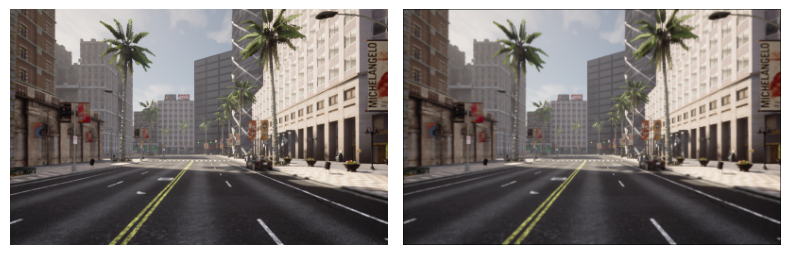

In [38]:
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_q0, transform_q1, transform_01 = dataset[5]

identity = torch.eye(4)
image_r = reproject(depth_q, image_q.unsqueeze(0), dataset.K, identity).squeeze()

fig, axs = plt.subplots(1, 2, figsize=(8, 5))
for a in axs.ravel():
    a.axis('off')
axs[0].imshow(image_q.permute(1,2,0))
axs[1].imshow(image_r.permute(1,2,0))
plt.tight_layout()
plt.show()

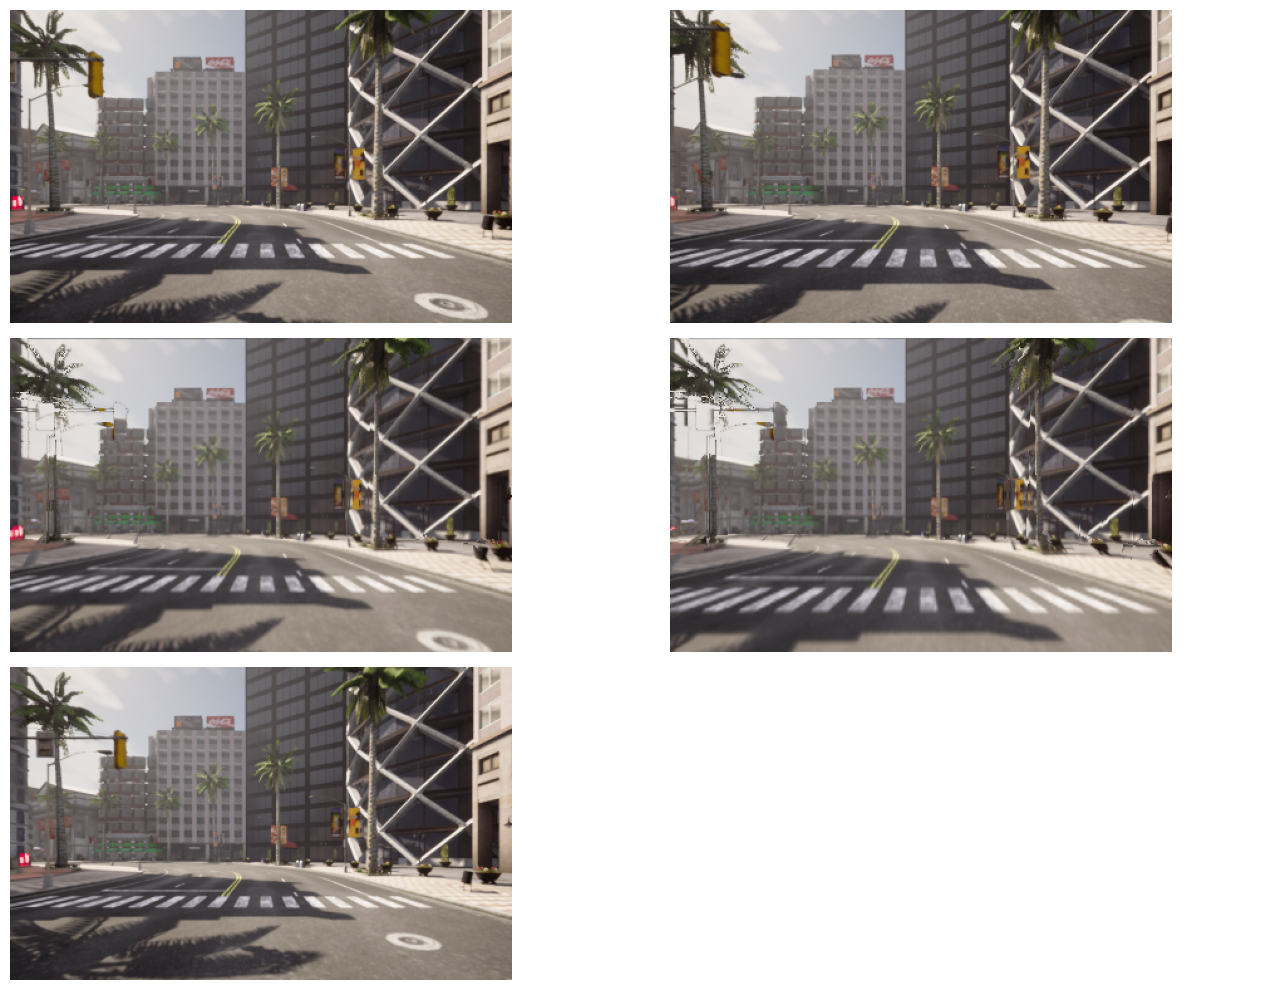

In [39]:
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_q0, transform_q1, transform_01 = dataset[65]  # 71, 65, 21, 5

image_q0 = reproject(depth_q, image_q.unsqueeze(0), dataset.K, transform_q0).squeeze()
image_q1 = reproject(depth_q, image_q.unsqueeze(0), dataset.K, transform_q1).squeeze()

fig, axs = plt.subplots(3, 2, figsize=(14, 10))
for a in axs.ravel():
    a.axis('off')
axs[0, 0].imshow(image_0.permute(1,2,0))
axs[0, 1].imshow(image_1.permute(1,2,0))
axs[1, 0].imshow(image_q0.permute(1,2,0))
axs[1, 1].imshow(image_q1.permute(1,2,0))
axs[2, 0].imshow(image_q.permute(1,2,0))
plt.tight_layout()
plt.show()

#save images

# for i in range(0,3):
#     for j in range(0,2):
#         fig = plt.figure()
#         fig.add_subplot(axs[i,j])
#         fig.savefig('image_{}.png'.format(i,j))



In [67]:
# plt.imshow(image_0.permute(1,2,0))
plt.imsave('report/image_wrong_q0.png', image_q0.permute(1,2,0).numpy())

Adam minimize Tqr & Gauss newton comparison

In [40]:
def gauss_newton(x, residuals, damping=1., iterations=5):
    # Unroll a number of iterations of Gauss-Newton.
    for i in range(0, iterations):
        # Compute the gauss-newton updates.
        R = residuals(x)
        # We need nan_to_num in case there are no errors..!
        J = torch.autograd.functional.jacobian(residuals, x)
        # https://en.wikipedia.org/wiki/Gauss–Newton_algorithm
        J = (j.sum(0, keepdim=True) for j in J)
        R = (-torch.atleast_1d(r) for r in R)
        # J.mT @ J, J.mT @ r
        u = torch.stack([
            torch.linalg.lstsq(j, -r).solution
            for j, r in zip(J, R)
        ])
        # Update x, but do nothing if the solution is bad
        x = x + damping * u.nan_to_num(0)  # continue iterating
        # if J.sum() ==0:
        #     print("jacobian is 0", "\n x", x, "\nr", r, "\nJ", J)
    return x

In [41]:
def align_feature_maps(K, features_q, saliency_q, features_r, saliency_r, depth_r, delta):
    def residuals(params):
        transform = transform_from_params(params).unsqueeze(1)
        features_estimated = reproject(depth_r, features_r, K, transform)
        saliency_estimated = reproject(depth_r, saliency_r, K, transform)
        errors = torch.nn.functional.huber_loss(features_q, features_estimated, reduction='none', delta=delta)
        errors = saliency_estimated * saliency_q * errors
        return tuple(error.sum() for error in errors)
    return residuals

In [42]:
def align_images(K, image_q, image_r, depth_r):
    def residuals(params):
        transform = transform_from_params(params).unsqueeze(1)
        image_est = reproject(depth_r, image_r, K, transform)
        errors = torch.nn.functional.huber_loss(image_q, image_est, reduction='none', delta=1)
        return tuple(error.sum() for error in errors)
    return residuals

In [64]:
dataloader_test = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)


In [79]:
K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_q0, transform_q1, transform_01 = dataset[5]
K = K.unsqueeze(0)
image_q = image_q.unsqueeze(0)
image_0 = image_0.unsqueeze(0)
image_1 = image_1.unsqueeze(0)
depth_q = depth_q.unsqueeze(0)
depth_0 = depth_0.unsqueeze(0)
depth_1 = depth_1.unsqueeze(0)
transform_q0 = transform_q0.unsqueeze(0)
transform_q1 = transform_q1.unsqueeze(0)
transform_01 = transform_01.unsqueeze(0)


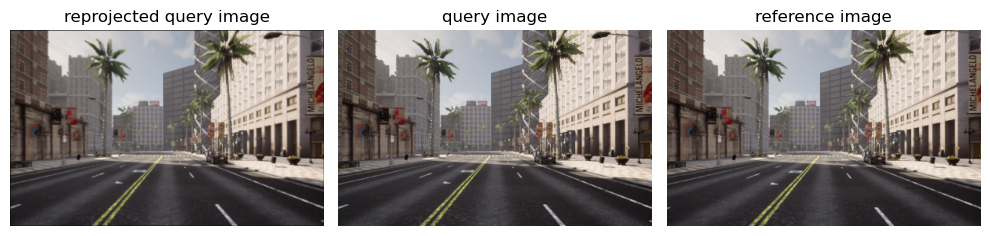

In [101]:
# guess = torch.zeros(len(K), 6)
# dataloader_test = torch.utils.data.DataLoader(dataset, batch_size=1)
# K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_q0, transform_q1, transform_01 = next(iter(dataloader_test))  # 71, 65, 21, 5
guess = params_from_transform(torch.eye(4).unsqueeze(0))

residual = align_images(K, image_q, image_0, depth_0)
estimate = gauss_newton(guess, residual, damping=0.01, iterations=10)
image_q0 = reproject(depth_q, image_q, K, transform_from_params(estimate).unsqueeze(1))
fig, axs = plt.subplots(len(K), 3, figsize=(10, 8))
for a in axs.ravel():
    a.axis('off')
axs[ 0].set_title('reprojected query image')
axs[ 1].set_title('query image')
axs[ 2].set_title('reference image')

axs[0].imshow(image_q0[0].permute(1,2,0))
axs[1].imshow(image_q [0].permute(1,2,0))
axs[2].imshow(image_0 [0].permute(1,2,0))
plt.tight_layout()
plt.show()

In [97]:
plt.imsave('report/image_q0_gauss.png', image_q0[0].permute(1,2,0).numpy())
plt.imsave('report/image_q_gauss.png', image_q [0].permute(1,2,0).numpy())
plt.imsave('report/image_0_gauss.png', image_0 [0].permute(1,2,0).numpy())

In [81]:
#adam
# K, image_q, image_0, image_1, depth_q, depth_0, depth_1, transform_q0, transform_q1, transform_01 = dataset[5]

# 3D points for the query image
points_3d = backproject(depth_q, dataset.K)
# 3D points for the reference image
# points_3d_ref = apply_transform(points_3d, transform_q0)
points_3d_ref = backproject(depth_0, dataset.K)
# intialize the parameter
# params = torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0, 0.0], requires_grad=True).unsqueeze(0)
# Tqr = transform_from_params(params).requires_grad_(True)
Tqr = torch.eye(4).unsqueeze(0).requires_grad_(True)
# optimizer
optimizer = torch.optim.Adam([Tqr], lr=0.01)
# loss function
loss_fn = torch.nn.MSELoss()
# number of iterations
n_iter = 100
for i in range(n_iter):
    optimizer.zero_grad()
    # transformed query points
    
    points_3d_ref_est = apply_transform(points_3d, Tqr)
    # compute the loss
    loss = loss_fn(points_3d_ref, points_3d_ref_est)
    # backpropagate the loss
    loss.backward()
    # update the parameters
    optimizer.step()
    # print the loss
    print('Iter {:04d} | Loss {:.6f}'.format(i, loss.item()))

Iter 0000 | Loss 1160.883789
Iter 0001 | Loss 1165.349487
Iter 0002 | Loss 1158.704834
Iter 0003 | Loss 1154.887207
Iter 0004 | Loss 1156.938599
Iter 0005 | Loss 1156.278198
Iter 0006 | Loss 1153.850586
Iter 0007 | Loss 1153.047485
Iter 0008 | Loss 1154.011108
Iter 0009 | Loss 1154.217651
Iter 0010 | Loss 1153.291992
Iter 0011 | Loss 1152.521606
Iter 0012 | Loss 1152.707520
Iter 0013 | Loss 1153.122803
Iter 0014 | Loss 1152.881348
Iter 0015 | Loss 1152.237061
Iter 0016 | Loss 1151.900757
Iter 0017 | Loss 1152.034058
Iter 0018 | Loss 1152.118164
Iter 0019 | Loss 1151.824829
Iter 0020 | Loss 1151.447144
Iter 0021 | Loss 1151.356323
Iter 0022 | Loss 1151.485718
Iter 0023 | Loss 1151.490356
Iter 0024 | Loss 1151.291260
Iter 0025 | Loss 1151.135010
Iter 0026 | Loss 1151.172852
Iter 0027 | Loss 1151.253540
Iter 0028 | Loss 1151.190796
Iter 0029 | Loss 1151.043701
Iter 0030 | Loss 1150.985840
Iter 0031 | Loss 1151.023438
Iter 0032 | Loss 1151.015381
Iter 0033 | Loss 1150.914307
Iter 0034 | Lo

In [89]:
image_q0_2.shape

torch.Size([1, 3, 250, 400])

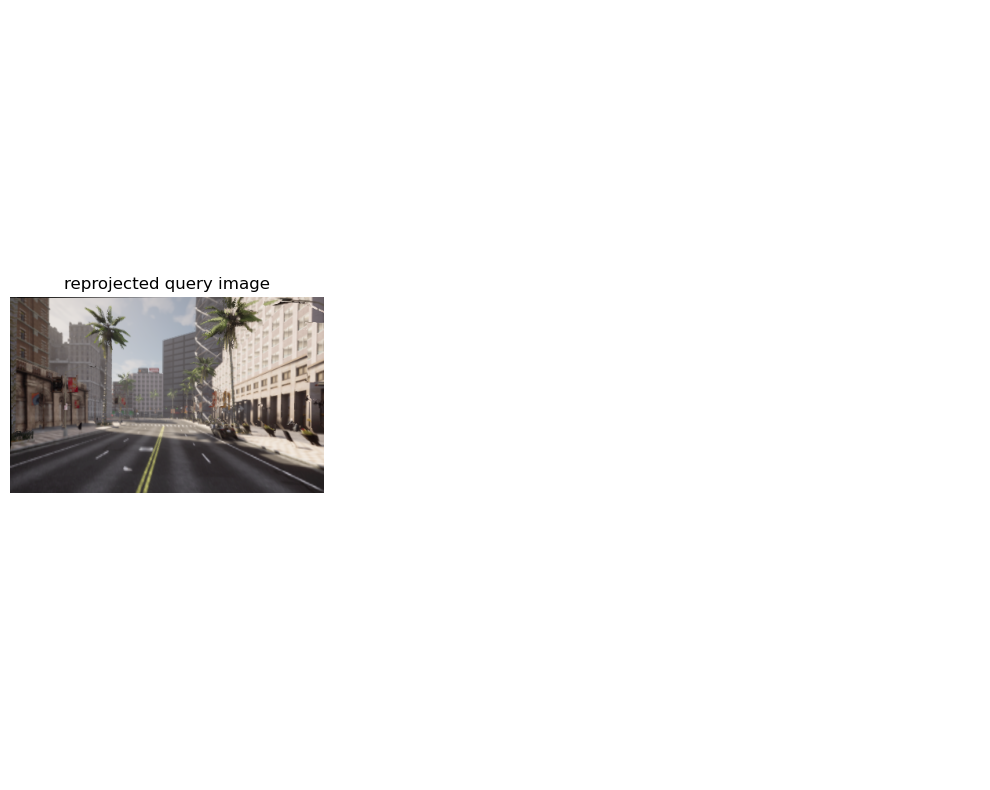

In [95]:
image_q0_2 = reproject(depth_q, image_q, K, Tqr.unsqueeze(0)).squeeze(0)
fig, axs = plt.subplots(len(K), 3, figsize=(10, 8))
for a in axs.ravel():
    a.axis('off')
axs[ 0].set_title('reprojected query image')
# axs[ 1].set_title('query image')
# axs[ 2].set_title('reference image')

axs[0].imshow(image_q0_2.permute(1,2,0).detach().numpy())
# axs[1].imshow(image_q.permute(1,2,0))
# axs[2].imshow(image_0.permute(1,2,0))
plt.tight_layout()
plt.show()

In [98]:
plt.imsave('report/image_q0_adam.png', image_q0_2.permute(1,2,0).detach().numpy())